In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import utm
import matplotlib.ticker as ticker
from itertools import groupby
import os, os.path
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score

In [2]:
def calculate_entropy(freq):
    Probabilities = []
    sum_of_all_freq=0
    for ele in range(0, len(freq)):
        sum_of_all_freq = sum_of_all_freq + freq[ele]
    max_size = len(freq)
    for i in range(max_size):
      Prob = freq[i]/sum_of_all_freq
      Probabilities.append(Prob)
    entropy_of_loc = -np.sum(Probabilities*np.log2(Probabilities))
    return entropy_of_loc

In [3]:
# load the data set
df = pd.read_csv('BrightKite_converted/user_10271.csv', encoding='utf-8')
df.head()

,Latitude,Longitude,Time
0,3.172331e+06,467969.295758,14.725556
1,3.170730e+06,464840.834110,2.572778
2,3.133824e+06,447698.686400,16.122500
3,3.167275e+06,469144.191065,14.788056
4,3.158725e+06,467277.817464,4.016667


In [4]:
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [5]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

### Mapping of points in a 3D space-time grid and calculate entropy after addition of each new point

In [6]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),10)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), 10)
Z = np.linspace(0,24,24)
d=1
grids_index = np.zeros((10,10,24))
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
allover_entropy=[]

for t in range(24):
    for yax in range(10):
        for xax in range(10):
            grids_index[xax,yax,t]=d
            d=d+1
            

for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            found_grid_index.append(int(found_at))
    frequency_of_grids = [len(list(group)) for key, group in groupby(found_grid_index)]
    current_entropy = calculate_entropy(frequency_of_grids)
    allover_entropy.append(current_entropy)

### Normalizing the data points

In [7]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

### Plot raw normalized data points

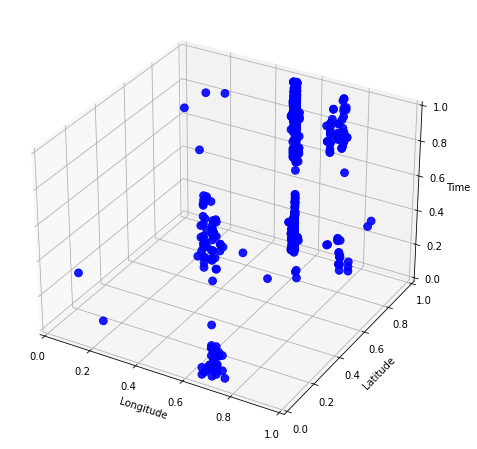

In [8]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
plt.show()

In [9]:
min_pts = (5/100)*len(lats_xy)
epsilon = 0.1

### Clustering of raw normalized data

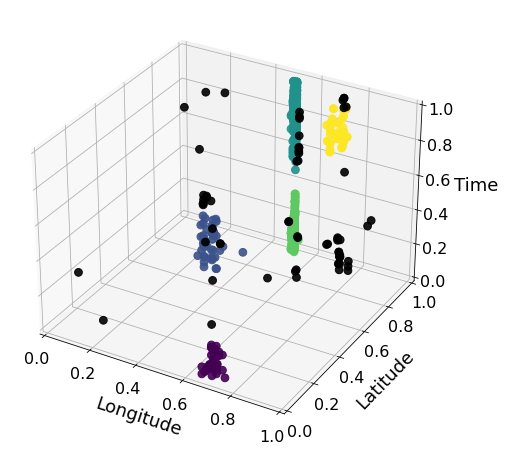

In [10]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
#plt.gca().add_artist(first_legend)
#plt.legend(loc='upper left')
plt.show()

In [11]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, db.labels_))

Silhouette Coefficient: 0.860


In [12]:
print(davies_bouldin_score(normalized_data, db.labels_))

0.27061970239215044


In [13]:
# get the number of clusters
num_clusters = len(set(db.labels_))
print(num_clusters)

6


### Find points that can be transmitted directly

In [14]:
threshold = 1
delta_1 = 0/100

In [15]:
max_limit = (threshold/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(len(allover_entropy)-1):
    if allover_entropy[temp] != 0:
        percent_change = ((allover_entropy[temp+1]-allover_entropy[temp])/allover_entropy[temp])*100
        if percent_change > delta_1:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [23]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [17]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [18]:
# Store maximum of 1% points in a grid
for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[user].tolist())
                                new_scaled_points.append(normalized_data.iloc[user].tolist())

In [19]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

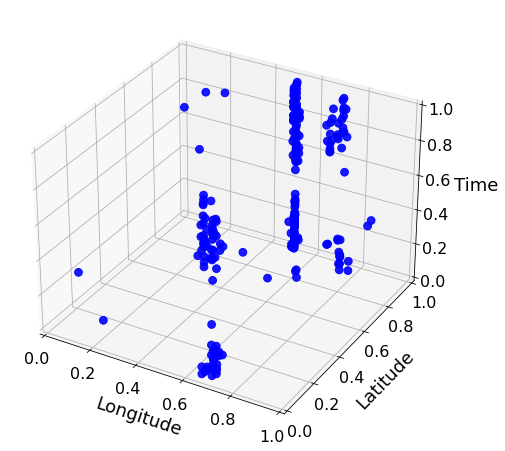

In [20]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
plt.show()

### Clustering of directly transmitted data points

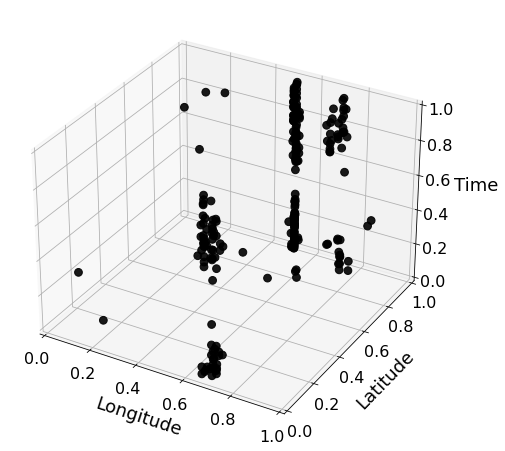

In [21]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(loc='upper left')
#plt.gca().add_artist(first_legend)
#plt.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=5, frameon=True)
plt.show()

In [22]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, db.labels_))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
print(davies_bouldin_score(normalized_data, db.labels_))

In [ ]:
# get the number of clusters
num_clusters = len(set(db.labels_))
print(num_clusters)